
# Moody’s Employment & Output Time Series (1970–2055)

Plots **Michigan** and **United States** time series by **Stage** and **Segment** for **Employment** and **Output (GDP)**, for the full range **1970–2055** and a subset **1990–2030**.

**Data source**: CSVs generated by `scripts/process_moodys_timeseries.py` into `data/interim/`.


In [8]:

from pathlib import Path
import os
import pandas as pd
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    sns.set_theme(context="talk", style="whitegrid")
except Exception:
    pass

def find_repo_root(markers=("data", "scripts")) -> Path:
    here = Path.cwd()
    for p in (here, *here.parents):
        if all((p / m).exists() for m in markers):
            return p
    return here

REPO_ROOT = find_repo_root()
os.chdir(REPO_ROOT)
print("Working dir ->", Path.cwd())

DATA_INTERIM = REPO_ROOT / "data" / "interim"
FIG_DIR = REPO_ROOT / "reports" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

print("Expecting CSVs in ->", DATA_INTERIM)


Working dir -> c:\Users\vasilauskas\GitHub\EV-Transition
Expecting CSVs in -> c:\Users\vasilauskas\GitHub\EV-Transition\data\interim


In [9]:

FILES = {
    "mi_segments": DATA_INTERIM / "moodys_michigan_segments_timeseries.csv",
    "us_segments": DATA_INTERIM / "moodys_us_segments_timeseries.csv",
    "mi_stages":   DATA_INTERIM / "moodys_michigan_stages_timeseries.csv",
    "us_stages":   DATA_INTERIM / "moodys_us_stages_timeseries.csv",
}

def require_exists(p: Path, label: str):
    if not p.exists():
        raise FileNotFoundError(
            f"Missing {label} at {p}. Generate it by running scripts/process_moodys_timeseries.py"
        )

for k, p in FILES.items():
    require_exists(p, k)


In [10]:

def load_csv(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    if "segment_label" in df.columns and "segment_name" not in df.columns:
        df = df.rename(columns={"segment_label": "segment_name"})
    for col in ["employment", "gdp"]:
        if col not in df.columns:
            df[col] = pd.NA
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")
    return df

def validate_columns(df: pd.DataFrame, required: list, df_name: str):
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"{df_name} missing columns: {missing}\nFound: {sorted(df.columns.tolist())}")


In [11]:

mi_segments = load_csv(FILES["mi_segments"])
us_segments = load_csv(FILES["us_segments"])
mi_stages   = load_csv(FILES["mi_stages"])
us_stages   = load_csv(FILES["us_stages"])

validate_columns(mi_segments, ["segment_id", "segment_name", "year", "employment", "gdp"], "mi_segments")
validate_columns(us_segments, ["segment_id", "segment_name", "year", "employment", "gdp"], "us_segments")
validate_columns(mi_stages,   ["stage", "year", "employment", "gdp"], "mi_stages")
validate_columns(us_stages,   ["stage", "year", "employment", "gdp"], "us_stages")

def clean_years(df, min_y=1970, max_y=2055):
    df = df.dropna(subset=["year"]).copy()
    df["year"] = df["year"].astype(int)
    return df[(df["year"] >= min_y) & (df["year"] <= max_y)].copy()

mi_segments = clean_years(mi_segments)
us_segments = clean_years(us_segments)
mi_stages   = clean_years(mi_stages)
us_stages   = clean_years(us_stages)

stage_order = ["Upstream", "OEM", "Downstream"]
for d in (mi_stages, us_stages):
    if "stage" in d.columns:
        d["stage"] = pd.Categorical(d["stage"], categories=stage_order, ordered=True)
        d.sort_values(["stage", "year"], inplace=True)

print("Shapes:")
print(" mi_segments:", mi_segments.shape, "years:", mi_segments["year"].min(), "–", mi_segments["year"].max())
print(" us_segments:", us_segments.shape, "years:", us_segments["year"].min(), "–", us_segments["year"].max())
print(" mi_stages:",   mi_stages.shape,   "years:", mi_stages["year"].min(),   "–", mi_stages["year"].max())
print(" us_stages:",   us_stages.shape,   "years:", us_stages["year"].min(),   "–", us_stages["year"].max())


Shapes:
 mi_segments: (1032, 6) years: 1970 – 2055
 us_segments: (1032, 6) years: 1970 – 2055
 mi_stages: (258, 5) years: 1970 – 2055
 us_stages: (258, 5) years: 1970 – 2055


In [14]:

def plot_timeseries(df: pd.DataFrame, group_col: str, metric_col: str,
                    title: str, outfile: Path, yr_min: int, yr_max: int,
                    legend_title: str | None = None, figsize=(14, 8)):
    sub = df[(df["year"] >= yr_min) & (df["year"] <= yr_max)].copy()
    sub = sub.dropna(subset=[metric_col])
    if sub.empty:
        print(f"[skip] No data for {title} ({yr_min}-{yr_max})")
        return

    fig, ax = plt.subplots(figsize=figsize)
    for name, g in sub.groupby(group_col, sort=False):
        ax.plot(g["year"], g[metric_col], label=str(name))

    ax.set_xlabel("Year")
    pretty = "Employment" if metric_col == "employment" else "Output (GDP)"
    ax.set_ylabel(pretty)
    ax.set_title(title)
    if legend_title is None:
        legend_title = group_col.replace("_", " ").title()
    ax.legend(title=legend_title, bbox_to_anchor=(1.02, 1), loc="upper left")
    fig.tight_layout()
    fig.savefig(outfile, dpi=300, bbox_inches="tight")
    print(f"Saved: {outfile}")
    plt.show()
    plt.close(fig)

def batch_plots(
    df: pd.DataFrame,
    group_col: str,
    geo_label: str,
    base_filename_prefix: str,
):
    """
    Emits four plots for this dataframe:
      - Employment (1970–2055)
      - Employment (1990–2030)
      - Output/GDP (1970–2055)
      - Output/GDP (1990–2030)
    """
    # Use friendly label in titles (avoid "Segment Name")
    display_label = "Stage" if group_col == "stage" else "Segment"

    items = [
        ("employment", (1970, 2055), f"{geo_label} {display_label} – Employment (1970–2055)"),
        ("employment", (1990, 2030), f"{geo_label} {display_label} – Employment (1990–2030)"),
        ("gdp",        (1970, 2055), f"{geo_label} {display_label} – Output (1970–2055)"),
        ("gdp",        (1990, 2030), f"{geo_label} {display_label} – Output (1990–2030)"),
    ]
    for metric, (ymin, ymax), title in items:
        suffix = f"{metric}_{ymin}_{ymax}.png"
        outfile = FIG_DIR / f"{base_filename_prefix}_{suffix}"
        legend_title = "Stage" if group_col == "stage" else "Segment"
        plot_timeseries(
            df=df,
            group_col=group_col,
            metric_col=metric,
            title=title,
            outfile=outfile,
            yr_min=ymin,
            yr_max=ymax,
            legend_title=legend_title,
            figsize=(12, 6) if group_col == "stage" else (14, 8),
        )


## Michigan — Stage & Segment

C:\Users\vasilauskas\AppData\Local\Temp\ipykernel_21240\2593010990.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, g in sub.groupby(group_col, sort=False):


Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\moodys_mi_stage_employment_1970_2055.png


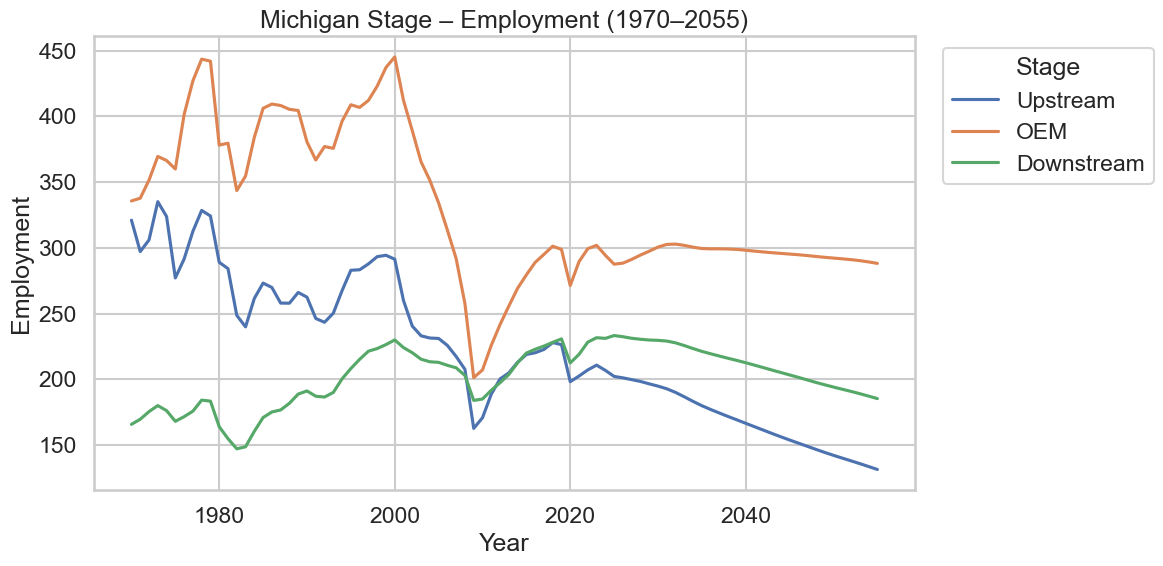

C:\Users\vasilauskas\AppData\Local\Temp\ipykernel_21240\2593010990.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, g in sub.groupby(group_col, sort=False):


Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\moodys_mi_stage_employment_1990_2030.png


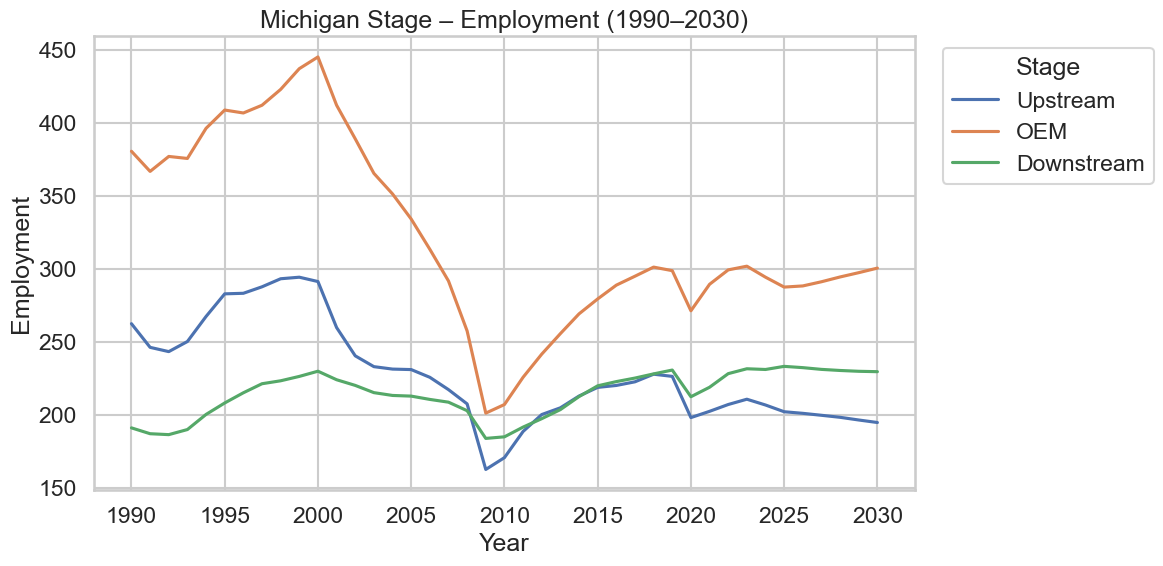

C:\Users\vasilauskas\AppData\Local\Temp\ipykernel_21240\2593010990.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, g in sub.groupby(group_col, sort=False):


Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\moodys_mi_stage_gdp_1970_2055.png


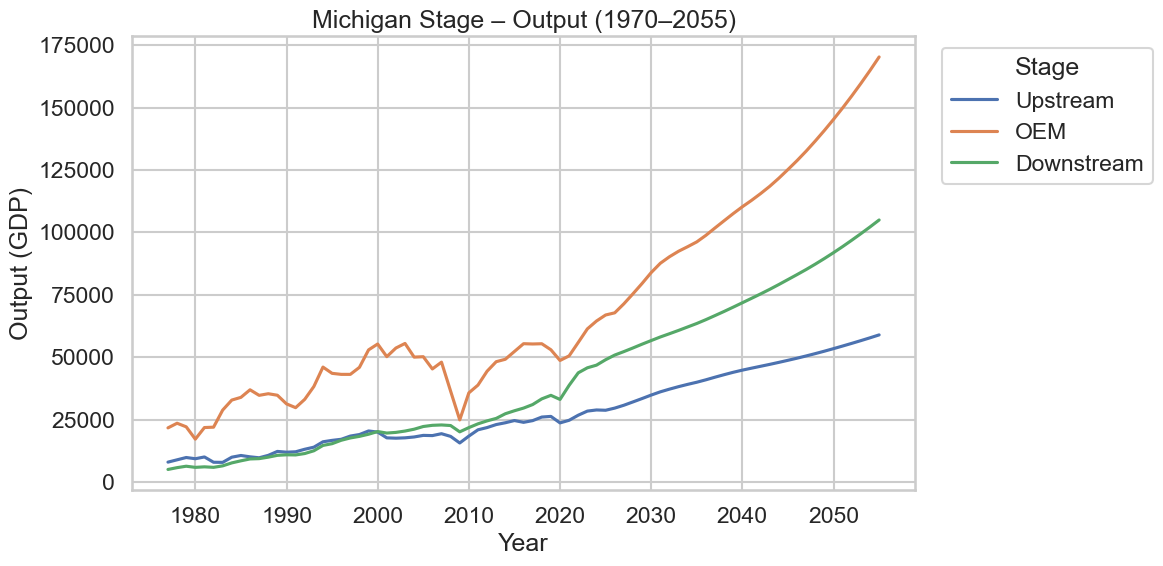

C:\Users\vasilauskas\AppData\Local\Temp\ipykernel_21240\2593010990.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, g in sub.groupby(group_col, sort=False):


Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\moodys_mi_stage_gdp_1990_2030.png


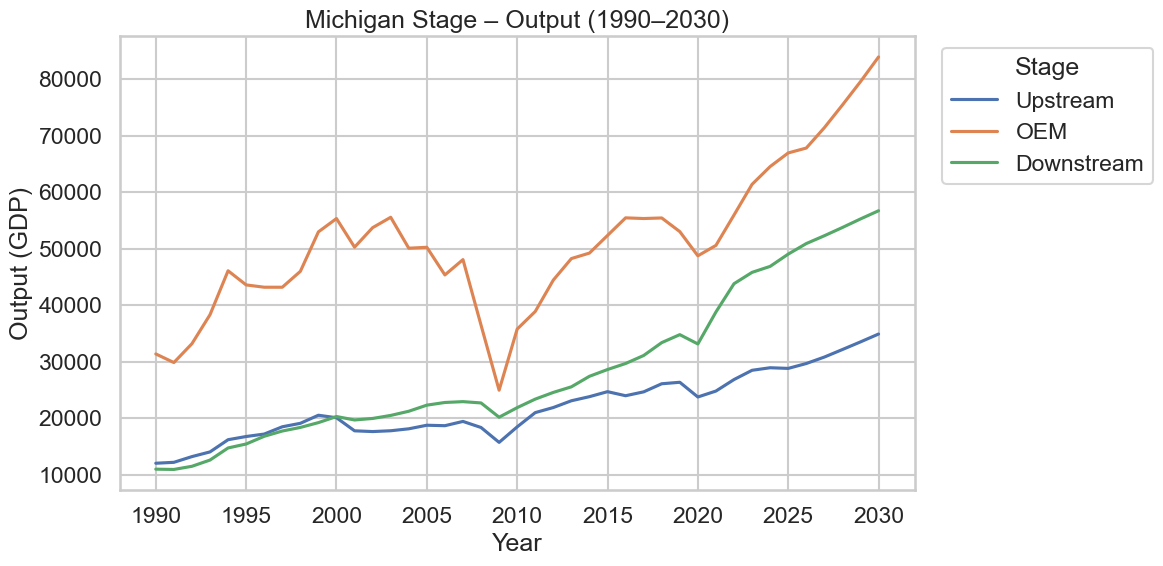

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\moodys_mi_segment_employment_1970_2055.png


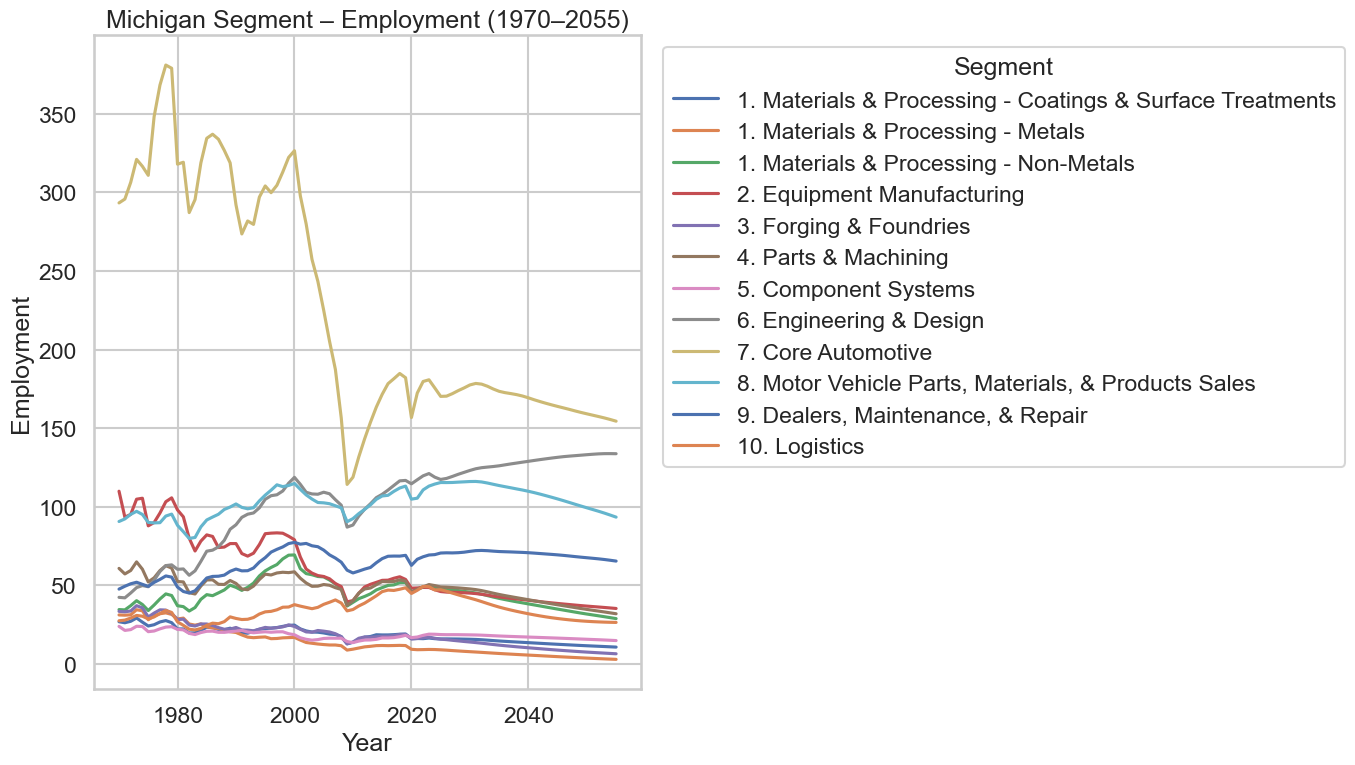

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\moodys_mi_segment_employment_1990_2030.png


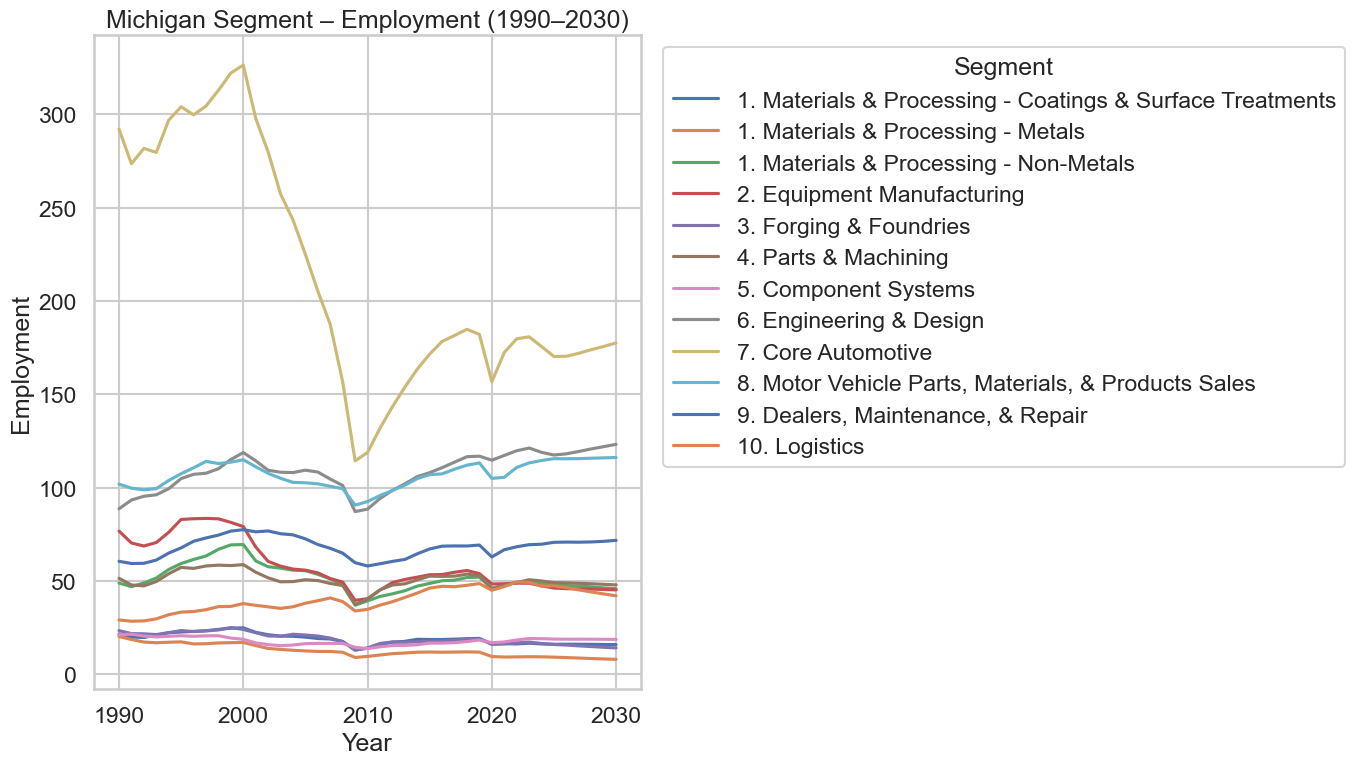

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\moodys_mi_segment_gdp_1970_2055.png


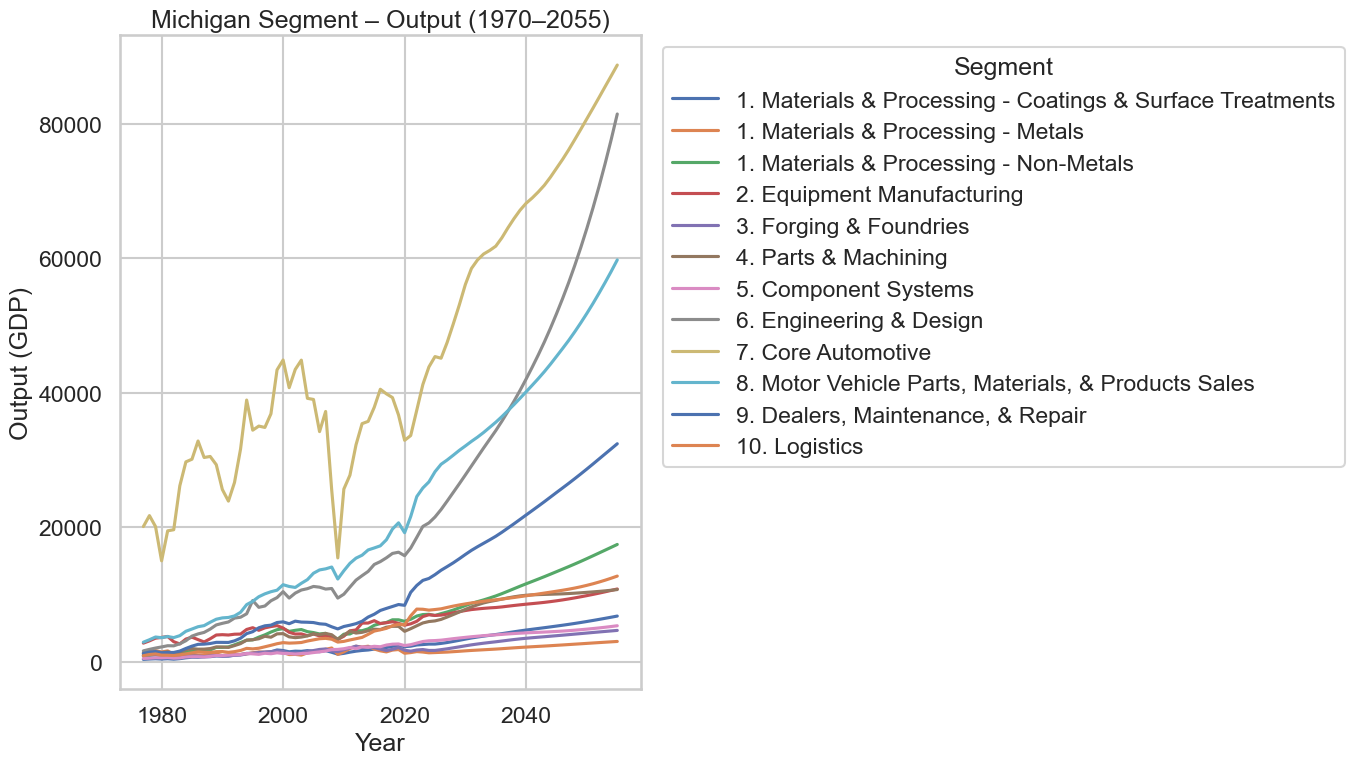

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\moodys_mi_segment_gdp_1990_2030.png


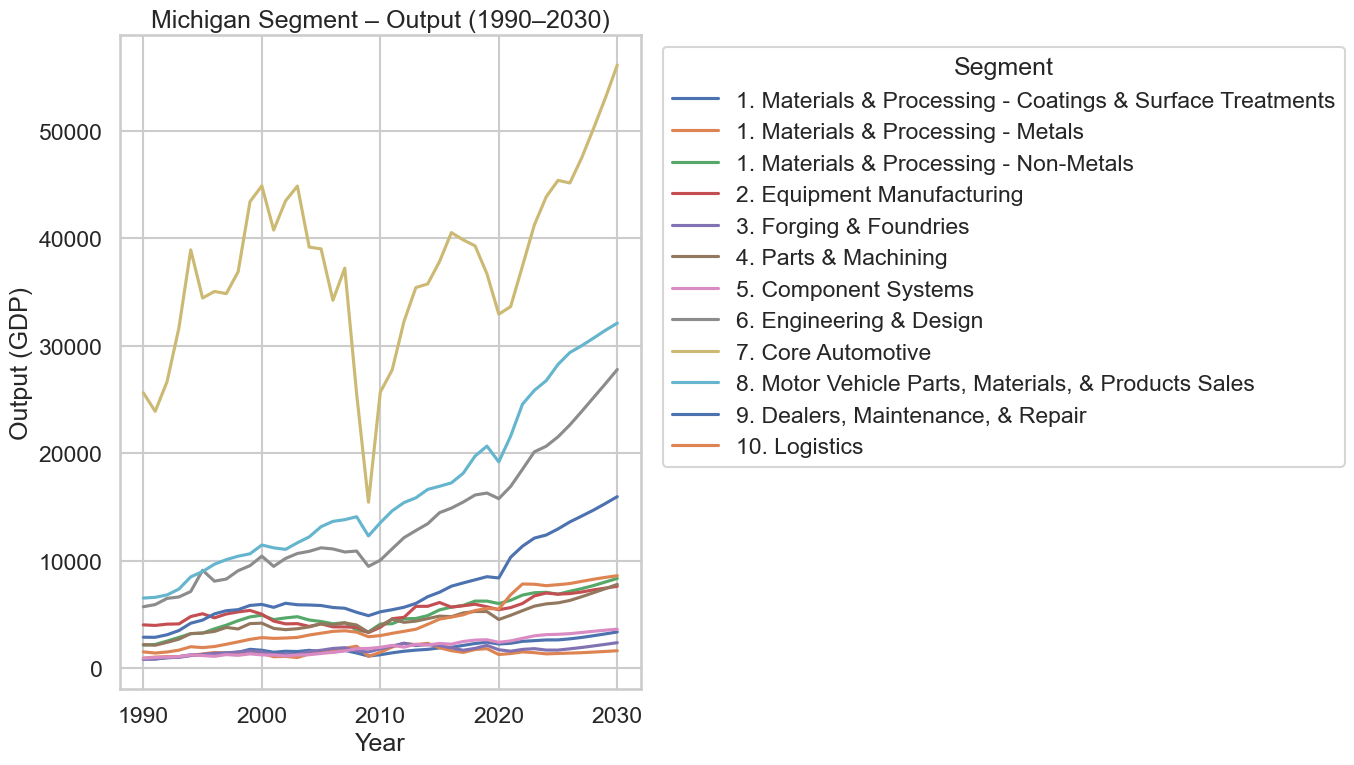

In [15]:

batch_plots(mi_stages,   group_col="stage",        geo_label="Michigan",      base_filename_prefix="moodys_mi_stage")
batch_plots(mi_segments, group_col="segment_name", geo_label="Michigan",      base_filename_prefix="moodys_mi_segment")


## United States — Stage & Segment

C:\Users\vasilauskas\AppData\Local\Temp\ipykernel_21240\2593010990.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, g in sub.groupby(group_col, sort=False):


Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\moodys_us_stage_employment_1970_2055.png


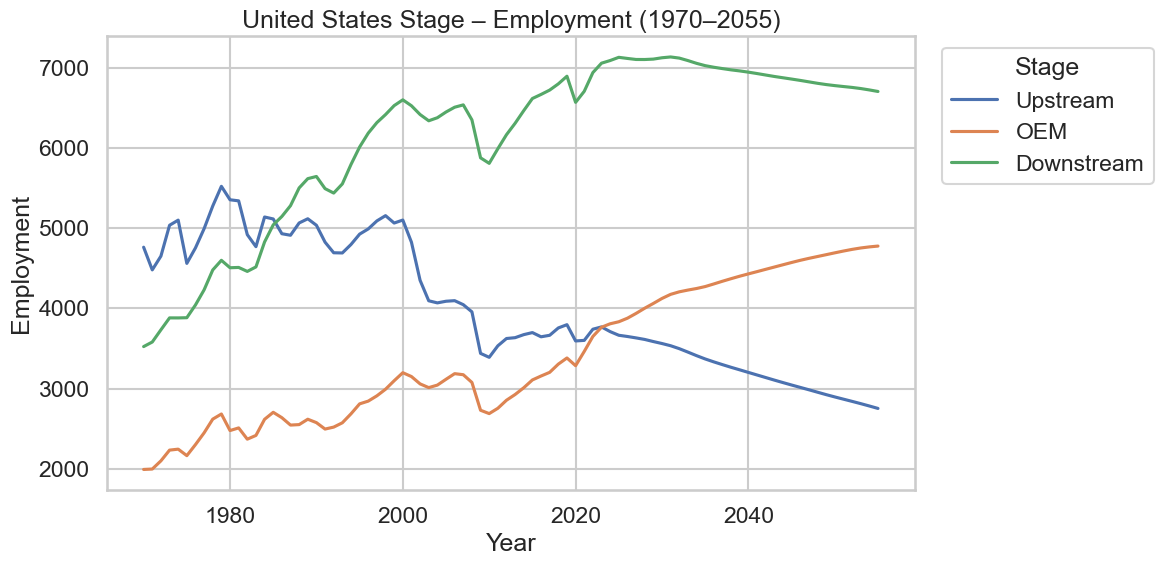

C:\Users\vasilauskas\AppData\Local\Temp\ipykernel_21240\2593010990.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, g in sub.groupby(group_col, sort=False):


Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\moodys_us_stage_employment_1990_2030.png


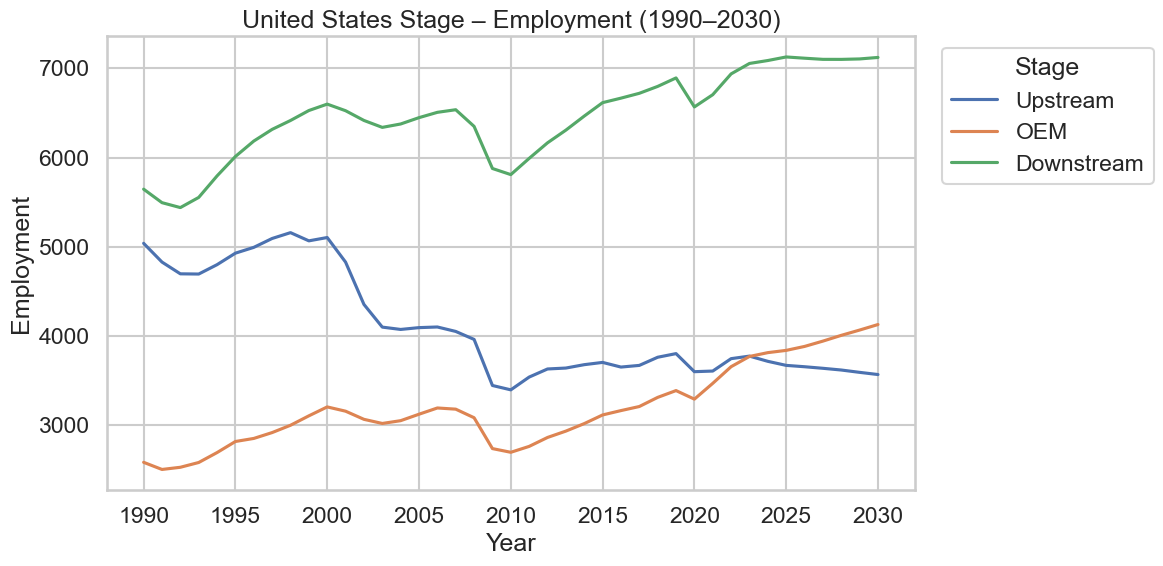

C:\Users\vasilauskas\AppData\Local\Temp\ipykernel_21240\2593010990.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, g in sub.groupby(group_col, sort=False):


Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\moodys_us_stage_gdp_1970_2055.png


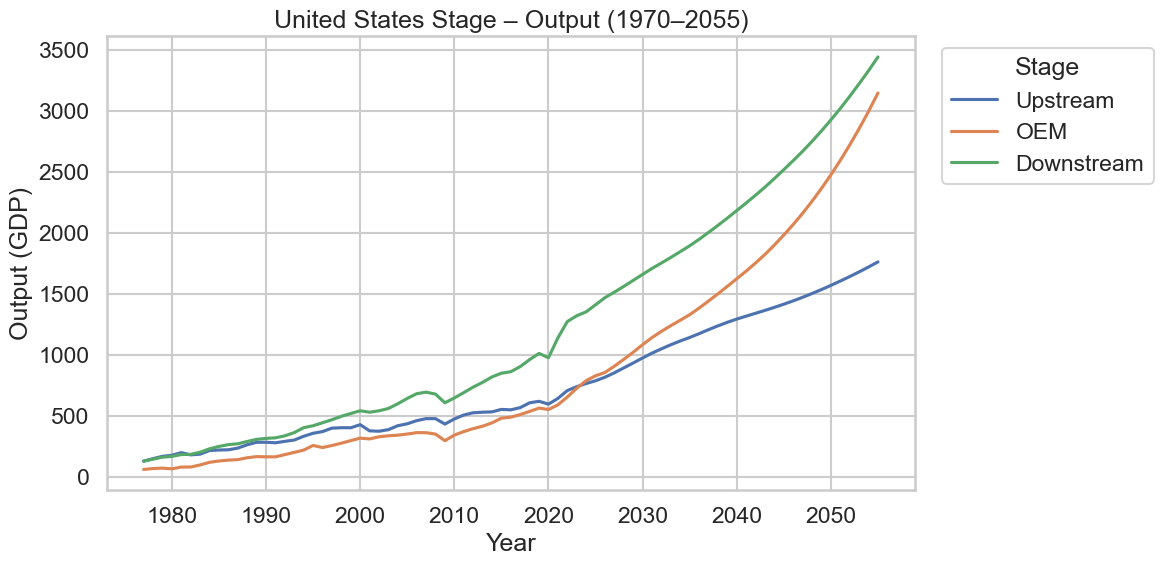

C:\Users\vasilauskas\AppData\Local\Temp\ipykernel_21240\2593010990.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, g in sub.groupby(group_col, sort=False):


Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\moodys_us_stage_gdp_1990_2030.png


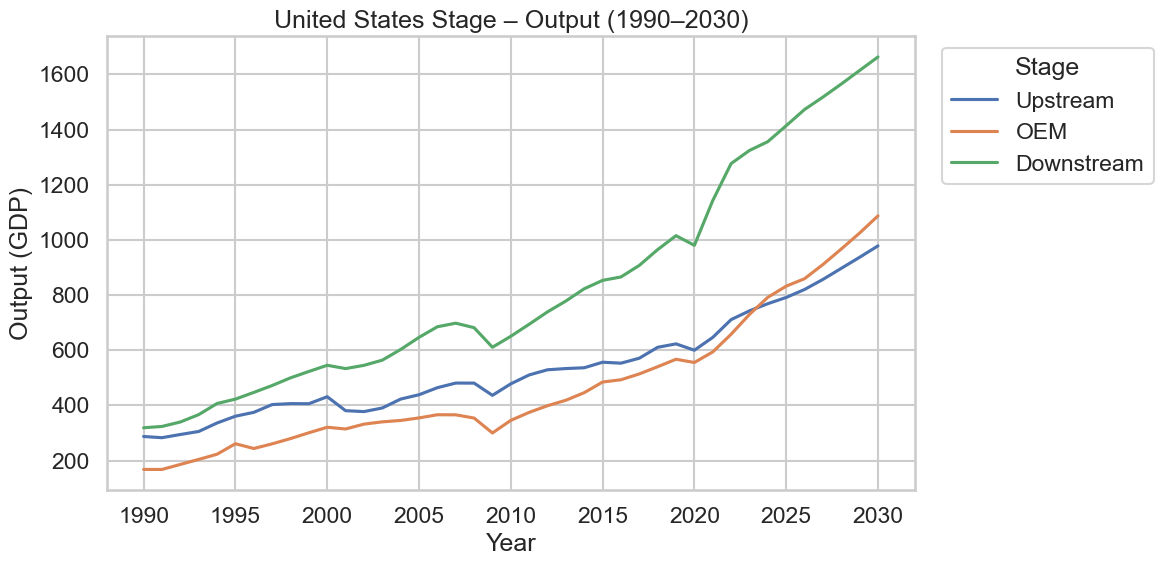

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\moodys_us_segment_employment_1970_2055.png


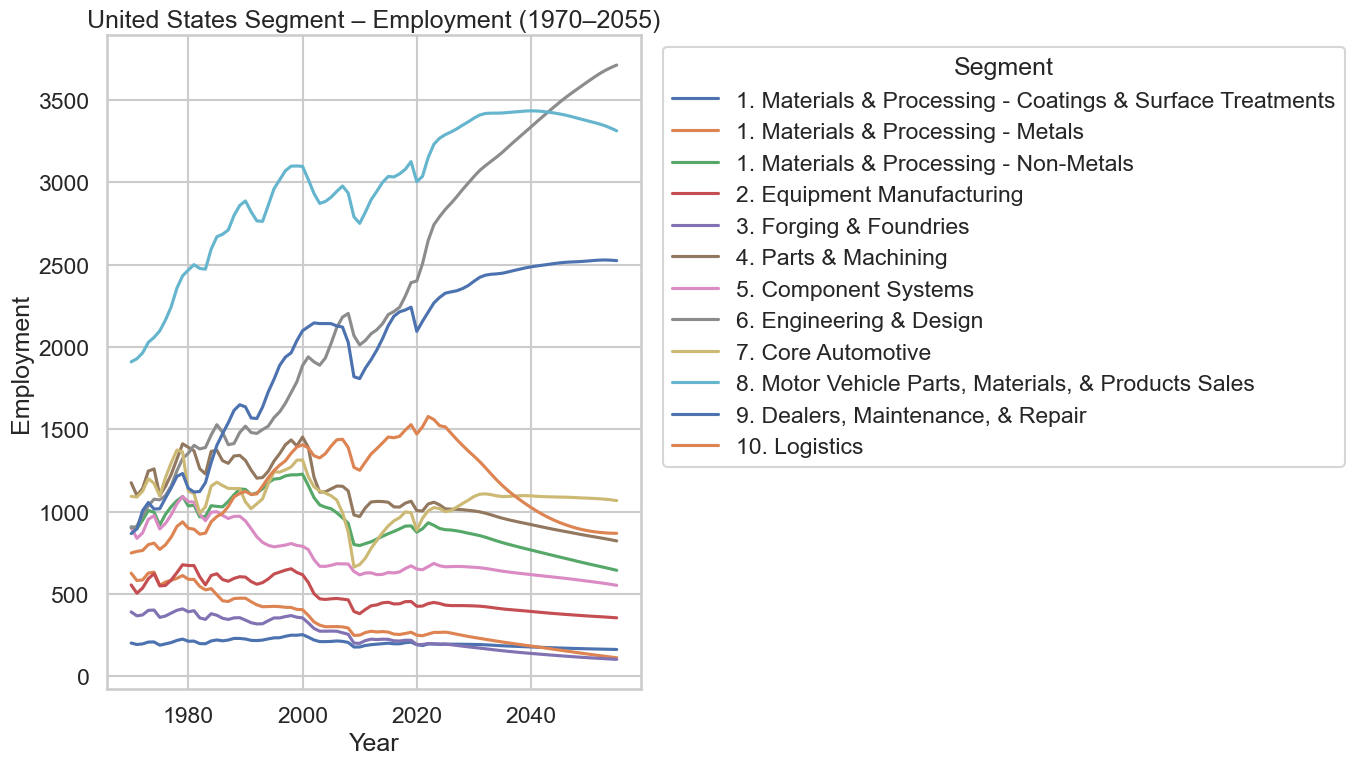

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\moodys_us_segment_employment_1990_2030.png


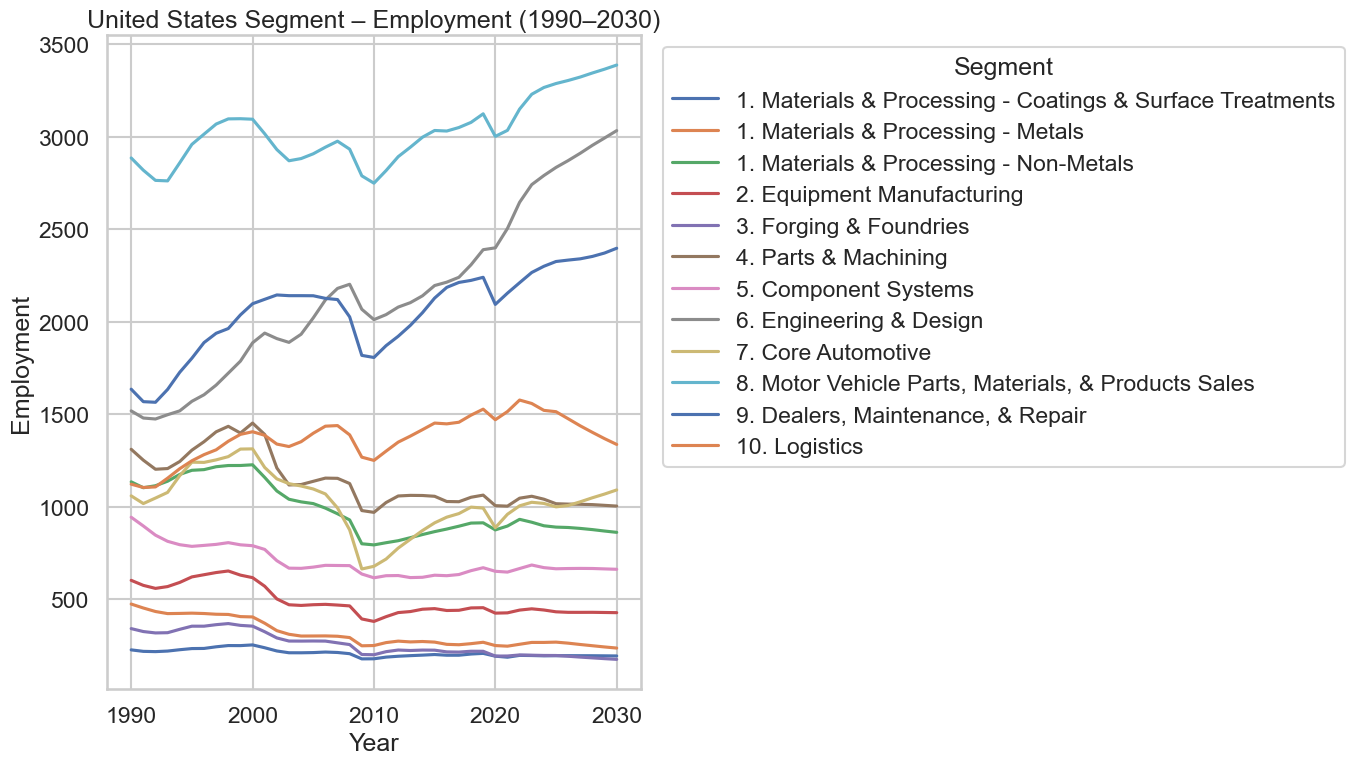

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\moodys_us_segment_gdp_1970_2055.png


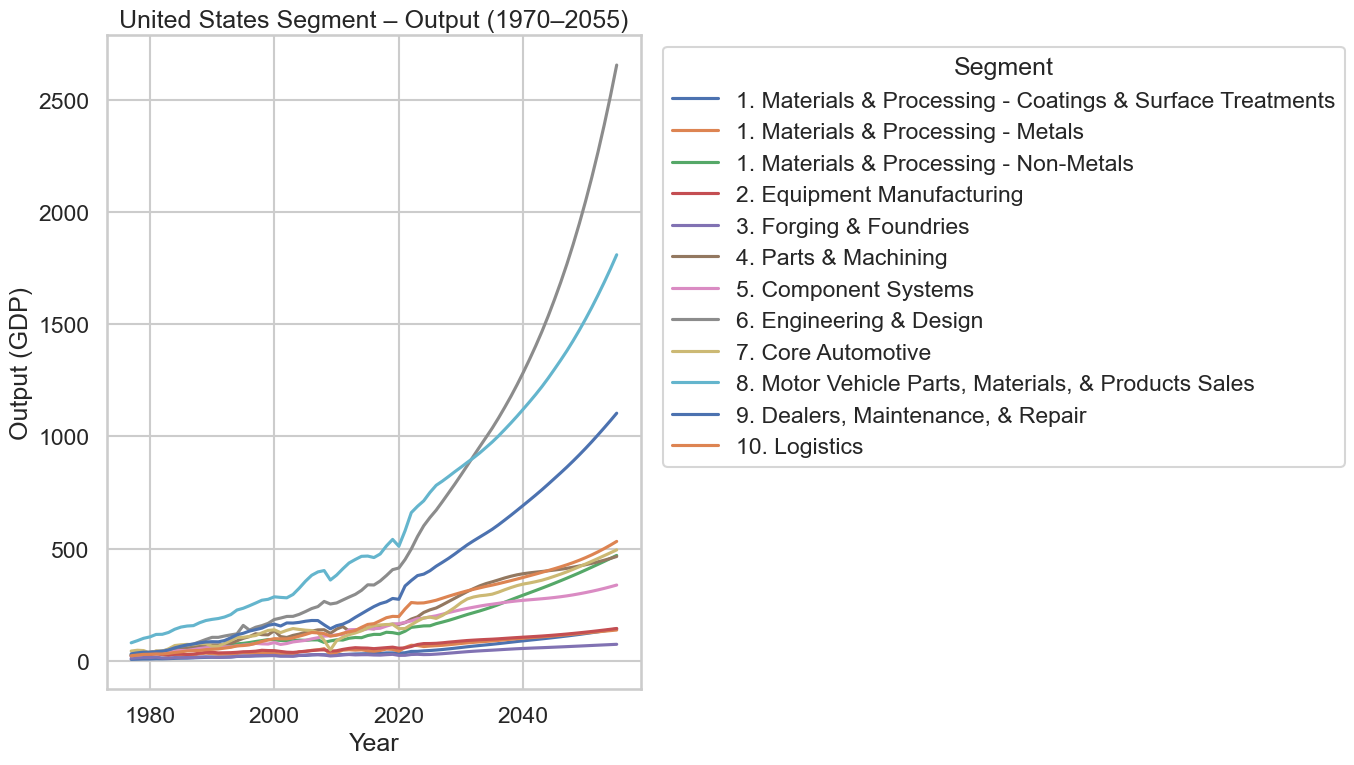

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\moodys_us_segment_gdp_1990_2030.png


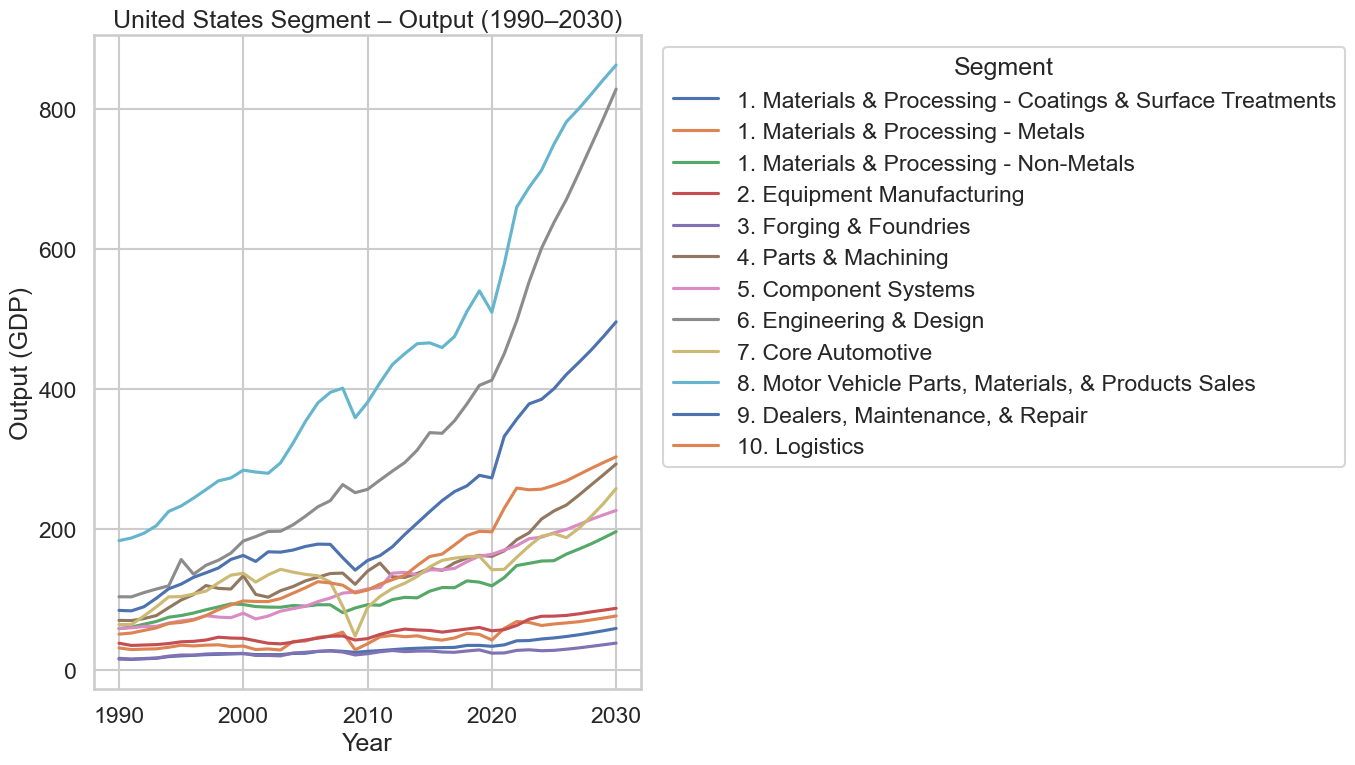

In [16]:

batch_plots(us_stages,   group_col="stage",        geo_label="United States", base_filename_prefix="moodys_us_stage")
batch_plots(us_segments, group_col="segment_name", geo_label="United States", base_filename_prefix="moodys_us_segment")



### Export an *executed* Markdown report

```bash
jupyter nbconvert --to markdown --execute notebooks/moodys_timeseries.ipynb   --output moodys_timeseries_executed.md   --output-dir reports/markdown   --ExecutePreprocessor.kernel_name=python3
```
